In [454]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.preprocessing import OneHotEncoder
from test import *

In [187]:
#now we do it for football.csv file
df = pd.read_csv('./titatnic.csv')
df=df.drop('Passengerid',axis=1)
df=df.dropna(axis=0)
df.corr()
y = df.pop('2urvived').to_numpy()
df=df.drop(['zero','zero.1','zero.2','zero.3','zero.4','zero.5','zero.6','zero.7','zero.8','zero.9','zero.10','zero.11','zero.12','zero.13','zero.14','zero.15','zero.16','zero.17','zero.18'],axis=1)
X = df.to_numpy() 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
X_train=X_train.reshape(X_train.shape[1],X_train.shape[0])
X_test=X_test.reshape(X_test.shape[1],X_test.shape[0])

In [59]:
def sigmoid(z):
        return 1 / (1 + np.exp(-z))

In [60]:
layer_sizes=[7,4,3,1]
weights=[]
biases=[]
for i in range(1, len(layer_sizes)):
    weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
    biases.append(np.zeros(shape=(layer_sizes[i],1))) 

In [61]:
weights[0].T.shape,weights[1].T.shape,weights[2].T.shape

((7, 4), (4, 3), (3, 1))

In [448]:
layers=3
weights = []
biases = []
for i in range(1, len(layer_sizes)):
    weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
    biases.append(np.zeros(shape=(layer_sizes[i],1))) 
z = [0] * layers
a = [0] * layers

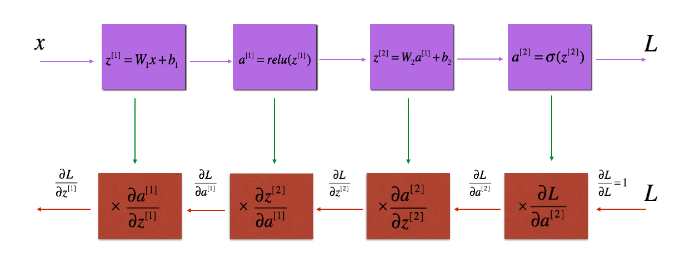

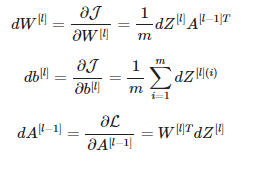

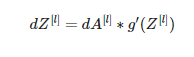

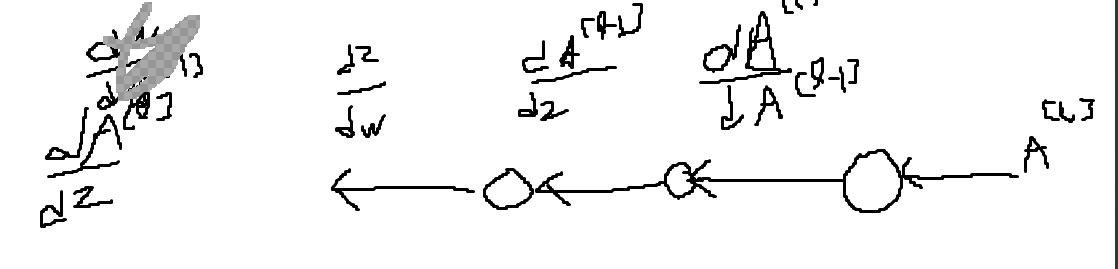

In [532]:
class NeuralNet:
    def __init__(self,layer_sizes, learning_rate,alpha=0.01):
        self.layers=len(layer_sizes)-1
        self.weights = []
        self.biases = []
        # for i in range(1,self.layers+1):
        #     self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
        #     self.biases.append(np.zeros(shape=(layer_sizes[i],1))) 
        for i in range(1, self.layers + 1):
            # Xavier initialization: weights are initialized with a variance of 2 / (n_in + n_out)
            n_in, n_out = layer_sizes[i - 1], layer_sizes[i]
            xavier_stddev = np.sqrt(2.0 / (n_in + n_out))
            self.weights.append(np.random.randn(n_out, n_in) * xavier_stddev)  # Normal distribution
            self.biases.append(np.zeros((n_out, 1)))

        self.learning_rate = learning_rate
        self.z = [0] * self.layers
        self.a = [0] * self.layers
        self.alpha=alpha
    def forward(self,X):
        for i in range(self.layers):
            #print(i)
            if i==0:
                #print(self.weights[i].shape,X.shape,self.biases[i].shape)
                self.z[i],self.a[i]=self.linear_forward(X,self.weights[i],self.biases[i],'relu')
            elif i==self.layers-1:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i],'sigmoid')
                #self.a[i]=self.z[i]
            else:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i],'relu')
            #if i!=0:
                #print(self.weights[i].shape,self.a[i-1].shape,self.biases[i].shape)
            #print(self.z[i].shape)
        return self.a[-1]
    def backward_propogate(self,Y,X):
        layers=self.layers-1
        gradA=[0]*self.layers
        gradb=[0]*self.layers
        gradW=[0]*self.layers
        #print(gradA)
        Y=Y.reshape(self.a[-1].shape)
        epsilon = 1e-8
        dJA = np.mean(np.divide(1 - Y, 1 - self.a[-1] + epsilon)-(np.divide(Y, self.a[-1] + epsilon)) )
        
        # y - 1/yhat - 1-y/1-yhat
        ##print(dJA.shape,self.a[self.layers-1].shape)
        #print(layers-1)
        gradA[layers-1], gradW[layers], gradb[layers] = self.linear_backward(dJA=dJA, Z=self.z[layers],A_prev=self.a[layers-1],W=self.weights[layers],b=self.biases[layers],activation='sigmoid')
        ##print(gradA[1].shape)
        for l in reversed(range(self.layers-1)):
            #print(l)
            if l==0:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],X,self.weights[l],self.biases[l] , activation = "relu")
            else:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],self.a[l-1],self.weights[l],self.biases[l] , activation = "relu")
            gradA[l-1] = dA_prev_temp
            gradW[l] = dW_temp
            gradb[l] = db_temp
        gradW = self.clip_gradients(gradW, 1.0)
        gradb = self.clip_gradients(gradb, 1.0)
        return gradW,gradb
    
    def clip_gradients(self, grads,clip_value):
        clipped_grads = []
        for grad in grads:
            clipped_grads.append(np.clip(grad, -clip_value, clip_value))
        return clipped_grads

    def optimize(self, gradW, gradb):
        # Clip gradients

        # Update weights and biases with clipped gradients
        for l in range(self.layers):
            self.weights[l] -= self.learning_rate * gradW[l]
            self.biases[l] -= self.learning_rate * gradb[l]

        return self.weights, self.biases
    
    def predict(self,X):
        a=self.a.copy()
        z=self.z.copy()
        weights=self.weights.copy()
        biases=self.biases.copy()
        for i in range(self.layers):
            #print(weights[i].shape,X.shape,biases[i].shape)
            if i==0:
                z[i],a[i]=self.linear_forward(X,weights[i],biases[i],'relu')
            elif i==self.layers-1:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i],'sigmoid')
            else:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i],'relu')
            #print(weights[i].shape,a[i-1].shape,biases[i].shape)
        return z[-1]
    def linear_backward(self,dJA,Z,A_prev,W,b, activation):
        m=A_prev.shape[1]
        #dJ/dZ = dJ/dA * dA/dZ
        #print(f"dJA          Z       A_prev      W      b")
        #print(f"{dJA.shape} {Z.shape} {A_prev.shape} {W.shape} {b.shape}")
        if activation == "relu":
            dJZ = np.array(dJA, copy=True)
            #dA/dZ Z>0 =1 else 0
            dJZ[Z <= 0] = 0
        elif activation == "sigmoid":
            s=1/(1+np.exp(-Z))
            dAZ=s*(1-s)
            dJZ = dJA*dAZ
        elif activation == "leaky_relu":
            dJZ = dJA * self.leaky_relu_derivative(Z, self.alpha)
        elif activation=='':
            dJZ=dJA
        #Z= WA+B
        #dZ/dW = A
        #dJ/dW=dZ/dW * dL/dZ
        #1/m to stabalize
        dJW=(1/m) * np.dot(dJZ, A_prev.T)
        #print("dJW = dJZ * A[l-1]")
        #print(f"{dJW.shape}= {dJZ.shape}*{A_prev.T.shape}")
        #print(f"W = {W.shape}")
        #dZ/db = 1
        #dJ/db=dJ/dZ *dZ/db
        dJb = (1/m)*np.sum(dJZ,axis=1,keepdims=True)
        #print("dJb = dJZ*1")
        #print(f"{dJW.shape}= {dJZ.shape}")        
        #dZ/dA =W
        #dJ/dA = dJ/dZ *dZ/dA
        dJA = np.dot(W.T,dJZ)
        #print("dJA = dZ/dA* dJ/dZ")
        #print(f"{dJA.shape}= {W.T.shape}*{dJZ.shape}")        
        ##print(dJb.shape,b.shape)
        assert (dJA.shape == A_prev.shape)
        assert (dJW.shape == W.shape)
        assert (dJb.shape == b.shape)

        return dJA, dJW, dJb 

    def linear_forward(self,A, W, b,activation=''):
        #A -- activations from previous layer (or input data): (size of previous layer, number of examples)
        #W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        #b -- bias vector, numpy array of shape (size of the current layer, 1)
        ##print(W.shape,A.shape,b.shape)
        Z=np.dot(W,A)+b
        #7,1045
        #1045,1
        #7,1
        ##print(Z.shape)
        n=A
        assert(Z.shape == (W.shape[0], A.shape[1]))
        if activation=='sigmoid':
            n=self.sigmoid(Z)
            #print(n)
        elif activation=='relu':
            n=self.relu(Z)
        elif activation == 'leaky_relu':
            n=self.leaky_relu(Z, self.alpha)
        return Z, n

    def Cost(self, yhat, Y):
        epsilon = 1e-8  # to avoid division by zero or log(0)
        Y=Y.flatten()
        yhat=yhat.flatten()
        m=len(Y)
        cost = (-1/m) * (np.dot(Y, np.log(yhat+epsilon).T) + np.dot((1-Y), np.log(1-yhat+epsilon).T))
        return cost
    @staticmethod
    def sigmoid_derivation(a):
        return a*(1-a)

    @staticmethod
    def leaky_relu(z, alpha=0.01):
        return np.where(z > 0, z, alpha * z)
    @staticmethod
    def leaky_relu_derivative(z, alpha=0.01):
        return np.where(z > 0, 1, alpha)

    @staticmethod
    def relu(z):
        return np.maximum(0,z)
    
    @staticmethod
    def sigmoid(z):
        return np.divide(1,(1 + np.exp(-z)))

In [473]:
n=NeuralNet(layer_sizes=[X_train.shape[0],4,2,1],learning_rate=0.001)

In [474]:
A, W, b = linear_forward_test_case()

Z, linear_cache = n.linear_forward(A, W, b)
print("Z = " + str(Z))
A_prev, W, b = linear_activation_forward_test_case()

Z = [[ 3.26295337 -1.23429987]]


In [476]:
Z, A = n.linear_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

Z, A = n.linear_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

[[0.96890023 0.11013289]]
With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


In [491]:
X, parameters = L_model_forward_test_case_2hidden()
w=[]
b=[]
w.append(parameters['W1'])
w.append(parameters['W2'])
w.append(parameters['W3'])
b.append(parameters['b1'])
b.append(parameters['b2'])
b.append(parameters['b3'])
n.weights=w
n.biases=b
AL = n.forward(X)
print(AL)

In [500]:
Y, AL = compute_cost_test_case()
print("cost = " + str(n.Cost(AL, Y)))

cost = 0.27977655015341635


In [526]:
linear_cache

(array([[-0.3224172 , -0.38405435,  1.13376944, -1.09989127],
        [-0.17242821, -0.87785842,  0.04221375,  0.58281521],
        [-1.10061918,  1.14472371,  0.90159072,  0.50249434],
        [ 0.90085595, -0.68372786, -0.12289023, -0.93576943],
        [-0.26788808,  0.53035547, -0.69166075, -0.39675353]]),
 array([[-0.6871727 , -0.84520564, -0.67124613, -0.0126646 , -1.11731035],
        [ 0.2344157 ,  1.65980218,  0.74204416, -0.19183555, -0.88762896],
        [-0.74715829,  1.6924546 ,  0.05080775, -0.63699565,  0.19091548]]),
 array([[2.10025514],
        [0.12015895],
        [0.61720311]]))

In [529]:
dZ, cache = linear_backward_test_case()

A_prev, W, b = cache
m = A_prev.shape[1]

### START CODE HERE ### (≈ 3 lines of code)
dW = (1/m) * np.dot(dZ, A_prev.T)
db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
dA_prev = np.dot(W.T,dZ)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]


In [531]:
dJZ, linear_cache = linear_backward_test_case()
A_prev, W, b = linear_cache
m = A_prev.shape[1]
dJW=(1/m) * np.dot(dJZ, A_prev.T)
dJb = (1/m)*np.sum(dJZ,axis=1,keepdims=True)
dJA = np.dot(W.T,dJZ)
print ("dA_prev = "+ str(dJA))
print ("dW = " + str(dJW))
print ("db = " + str(dJb))

dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]


#Patch used epsilon smoothening for divide by 0 errors

In [533]:
#now we do it for football.csv file
df = pd.read_csv('./titatnic.csv')
df=df.drop('Passengerid',axis=1)
df=df.dropna(axis=0)
df.corr()
y = df.pop('2urvived').to_numpy()
df=df.drop(['zero','zero.1','zero.2','zero.3','zero.4','zero.5','zero.6','zero.7','zero.8','zero.9','zero.10','zero.11','zero.12','zero.13','zero.14','zero.15','zero.16','zero.17','zero.18'],axis=1)
X = df.to_numpy() 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.reshape(X_train.shape[1],X_train.shape[0])
X_test=X_test.reshape(X_test.shape[1],X_test.shape[0])

In [534]:
nn=NeuralNet(layer_sizes=[X_train.shape[0],32,32,1],learning_rate=0.01)

In [535]:
steps=1000
for i in range(steps):
    nn.forward(X_train)
    gradsW,gradsb=nn.backward_propogate(y_train,X_train)
    nn.optimize(gradsW,gradsb)
    pred=nn.predict(X_test)
    #print(pred.shape)
    y_pred = np.where(pred >= 0.5, 1, 0).flatten()
    #print(y_train.shape,y_test.shape)
    print(nn.Cost(np.where(nn.a[-1]>= 0.5, 1, 0).flatten(),y_train),nn.Cost(y_pred,y_test))

13.661270405610617 4.851247974819516
13.661270405610617 4.851247974819516
13.661270405610617 4.8512479748195165
13.661270405610617 4.851247974819516
13.661270405610617 4.851247974819516
13.661270405610617 4.851247974819516
13.608388068517932 4.851247974819516
13.520250840030121 4.851247974819516
13.467368502937434 4.851247974819516
13.414486165844746 4.9215559166284955
13.308721491659373 4.9215559166284955
13.202956817474002 4.9215559166284955
13.079564697591067 4.9215559166284955
12.95617257770813 4.9215559166284955
12.920917686313006 4.9215559166284955
12.832780457825194 4.9215559166284955
12.744643229337385 4.9215559166284955
12.762270675034946 4.9215559166284955
12.656506000849573 4.9215559166284955
12.480231543873954 4.9215559166284955
12.339211978293454 4.9215559166284955
12.32158453259589 4.9215559166284955
12.303957086898329 4.9215559166284955
12.180564967015394 4.9215559166284955
12.039545401434896 4.9215559166284955
11.916153281551962 4.9215559166284955
11.757506270273902 4.9

In [320]:
y_test

array([ 5, 14, 14, ..., 14, 14, 14])

In [208]:
df = pd.read_csv('./house_prices.csv')
df=df.drop("Unnamed: 0",axis=1)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['location']=label_encoder.fit_transform(df['location'])
df['city']=label_encoder.fit_transform(df['city'])
df['purpose']=label_encoder.fit_transform(df['purpose'])
df['property_type']=label_encoder.fit_transform(df['property_type'])
df['Area_in_Marla']=label_encoder.fit_transform(df['Area_in_Marla'])
df=df.drop('location',axis=1)
from sklearn.preprocessing import MinMaxScaler
y=df.pop('price').to_numpy()
scaler = MinMaxScaler()
X = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
X = pd.DataFrame(X, columns=df.columns)
X=X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.reshape(X_train.shape[1],X_train.shape[0])
X_test=X_test.reshape(X_test.shape[1],X_test.shape[0])


In [123]:
#now we do it for football.csv file
df = pd.read_csv('football.csv')
df=df.drop('Team',axis=1)
df.corr()
y = df.pop('Points').to_numpy()
X = df.to_numpy() 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train=X_train.reshape(X_train.shape[1],X_train.shape[0])
X_test=X_test.reshape(X_test.shape[1],X_test.shape[0])

In [209]:
class NeuralNet:
    def __init__(self,layer_sizes, learning_rate,lamb=0.01,alpha=0.01):
        self.layers=len(layer_sizes)-1
        self.weights = []
        self.biases = []
        # for i in range(1,self.layers+1):
        #     self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
        #     self.biases.append(np.zeros(shape=(layer_sizes[i],1))) 
        for i in range(1, self.layers + 1):
            # Xavier initialization: weights are initialized with a variance of 2 / (n_in + n_out)
            n_in, n_out = layer_sizes[i - 1], layer_sizes[i]
            xavier_stddev = np.sqrt(2.0 / (n_in + n_out))
            self.weights.append(np.random.randn(n_out, n_in) * xavier_stddev)  # Normal distribution
            self.biases.append(np.zeros((n_out, 1)))

        self.learning_rate = learning_rate
        self.z = [0] * self.layers
        self.a = [0] * self.layers
        self.lambda_reg=lamb
        self.alpha=alpha
    def forward(self,X):
        for i in range(self.layers):
            #if i==0:
                #print(self.weights[i].shape,X.shape,self.biases[i].shape)
            if i==0:
                self.z[i],self.a[i]=self.linear_forward(X,self.weights[i],self.biases[i],'leaky_relu')
            elif i==self.layers-1:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i])
                self.a[i]=self.z[i]
            else:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i],'leaky_relu')
            #if i!=0:
                #print(self.weights[i].shape,self.a[i-1].shape,self.biases[i].shape)
            #print(self.z[i].shape)
        return self.a[-1]
    def backward_propogate(self,Y,X):
        layers=self.layers-1
        gradA=[0]*self.layers
        gradb=[0]*self.layers
        gradW=[0]*self.layers
        #print(gradA)
        #print(self.a[-1])
        for l in range(self.layers):
            gradW[l] += (self.lambda_reg / X.shape[1]) * self.weights[l]  # Adding L2 regularization term to gradient
        Y=Y.reshape(self.a[-1].shape)
        epsilon = 1e-8
        dJA =(self.a[-1] - Y)
        ##print(dJA.shape,self.a[self.layers-1].shape)
        #print(layers-1)
        gradA[layers-1], gradW[layers], gradb[layers] = self.linear_backward(dJA=dJA, Z=self.z[layers],A_prev=self.a[layers-1],W=self.weights[layers],b=self.biases[layers],activation='')
        ##print(gradA[1].shape)
        for l in reversed(range(self.layers-1)):
            #print(l)
            if l==0:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],X,self.weights[l],self.biases[l] , activation = "leaky_relu")
            else:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],self.a[l-1],self.weights[l],self.biases[l] , activation = "leaky_relu")
            gradA[l-1] = dA_prev_temp
            gradW[l] = dW_temp
            gradb[l] = db_temp
        gradW = self.clip_gradients(gradW, 1.0)
        gradb = self.clip_gradients(gradb, 1.0)
        return gradW,gradb
    
    def clip_gradients(self, grads,clip_value):
        clipped_grads = []
        for grad in grads:
            clipped_grads.append(np.clip(grad, -clip_value, clip_value))
        return clipped_grads

    def optimize(self, gradW, gradb):
        # Clip gradients

        # Update weights and biases with clipped gradients
        for l in range(self.layers):
            self.weights[l] -= self.learning_rate * gradW[l]
            self.biases[l] -= self.learning_rate * gradb[l]

        return self.weights, self.biases
    
    def predict(self,X):
        a=self.a.copy()
        z=self.z.copy()
        weights=self.weights.copy()
        biases=self.biases.copy()
        for i in range(self.layers):
            #print(weights[i].shape,X.shape,biases[i].shape)
            if i==0:
                z[i],a[i]=self.linear_forward(X,weights[i],biases[i],'leaky_relu')
            elif i==self.layers-1:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i])
            else:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i],'leaky_relu')
            #print(weights[i].shape,a[i-1].shape,biases[i].shape)
        return z[-1]
    def linear_backward(self,dJA,Z,A_prev,W,b, activation):
        m=A_prev.shape[1]
        #dJ/dZ = dJ/dA * dA/dZ
        #print(f"dJA          Z       A_prev      W      b")
        #print(f"{dJA.shape} {Z.shape} {A_prev.shape} {W.shape} {b.shape}")
        if activation == "relu":
            dJZ = np.array(dJA, copy=True)
            #dA/dZ Z>0 =1 else 0
            dJZ[Z <= 0] = 0
        elif activation == "sigmoid":
            s=1/(1+np.exp(-Z))
            dAZ=s*(1-s)
            dJZ = dJA*dAZ
        elif activation == "leaky_relu":
            dJZ = dJA * self.leaky_relu_derivative(Z, self.alpha)
        elif activation=='':
            dJZ=dJA
        #Z= WA+B
        #dZ/dW = A
        #dJ/dW=dZ/dW * dL/dZ
        #1/m to stabalize
        dJW=(1/m) * np.dot(dJZ, A_prev.T)
        #print("dJW = dJZ * A[l-1]")
        #print(f"{dJW.shape}= {dJZ.shape}*{A_prev.T.shape}")
        #print(f"W = {W.shape}")
        #dZ/db = 1
        #dJ/db=dJ/dZ *dZ/db
        dJb = (1/m)*np.sum(dJZ,axis=1,keepdims=True)
        #print("dJb = dJZ*1")
        #print(f"{dJW.shape}= {dJZ.shape}")        
        #dZ/dA =W
        #dJ/dA = dJ/dZ *dZ/dA
        dJA = (1/m)*np.dot(W.T,dJZ)
        #print("dJA = dZ/dA* dJ/dZ")
        #print(f"{dJA.shape}= {W.T.shape}*{dJZ.shape}")        
        ##print(dJb.shape,b.shape)
        assert (dJA.shape == A_prev.shape)
        assert (dJW.shape == W.shape)
        assert (dJb.shape == b.shape)

        return dJA, dJW, dJb 

    def linear_forward(self,A, W, b,activation=''):
        #A -- activations from previous layer (or input data): (size of previous layer, number of examples)
        #W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        #b -- bias vector, numpy array of shape (size of the current layer, 1)
        ##print(W.shape,A.shape,b.shape)
        Z=np.dot(W,A)+b
        ##print(Z.shape)
        assert(Z.shape == (W.shape[0], A.shape[1]))
        if activation=='sigmoid':
            A=self.sigmoid(Z)
        elif activation=='relu':
            A=self.relu(Z)
        elif activation == 'leaky_relu':
            A = self.leaky_relu(Z, self.alpha)
        return Z, A

    def Cost(self, yhat, Y):
        m = Y.shape[0]
        cost = ((Y - yhat) ** 2).mean()
        L2_regularization_cost = (self.lambda_reg / (2 * m)) * sum([np.sum(np.square(w)) for w in self.weights])
        return cost + L2_regularization_cost
    @staticmethod
    def sigmoid_derivation(a):
        return a*(1-a)

    @staticmethod
    def leaky_relu(z, alpha=0.01):
        return np.where(z > 0, z, alpha * z)
    @staticmethod
    def leaky_relu_derivative(z, alpha=0.01):
        return np.where(z > 0, 1, alpha)

    @staticmethod
    def relu(z):
        return np.maximum(0,z)
    
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

In [212]:
nn=NeuralNet(layer_sizes=[X_train.shape[0],64,8,1],learning_rate=0.01,lamb=0.000)
steps=1000
for i in range(steps):
    nn.forward(X_train)
    gradsW,gradsb=nn.backward_propogate(y_train,X_train)
    mean_gradsW = [np.mean(gw) for gw in gradsW]
    mean_gradsb = [np.mean(gb) for gb in gradsb]
    #print(f"Step {i+1}, Mean Gradients Weights: {mean_gradsW}, Mean Gradients Biases: {mean_gradsb}")
    #print(f"Step {i+1},  Weights: {nn.weights},  Biases: {nn.biases}")
    nn.optimize(gradsW,gradsb)
    #print(nn.a[-1].shape)
    y_pred=nn.predict(X_test).flatten()
    #print(y_pred.shape,y_test.shape)
    #print(f"Test = {nn.Cost(y_pred,y_test)}")
    print(mean_squared_error(nn.a[-1].flatten(),y_train),mean_squared_error(y_pred,y_test))

220673947512033.38 223774781621895.78
220673944566764.72 223774778409113.7
220673941407918.97 223774774969590.62
220673938012540.28 223774771275322.06
220673934363606.1 223774767349962.38
220673930494929.1 223774763234237.94
220673926437028.5 223774758937836.84
220673922204963.0 223774754457075.25
220673917789328.47 223774749784709.12
220673913178883.78 223774744918525.56
220673908375914.06 223774739856510.47
220673903381741.8 223774734598486.56
220673898196451.56 223774729147596.8
220673892821851.4 223774723504900.62
220673887258384.66 223774717670341.7
220673881505897.66 223774711644124.34
220673875564573.4 223774705426020.12
220673869434172.88 223774699015658.38
220673863114330.1 223774692412850.44
220673856604873.12 223774685617388.94
220673849905618.84 223774678628991.97
220673843016283.84 223774671447634.12
220673835936816.34 223774664073074.97
220673828666982.38 223774656505157.94
220673821206619.62 223774648743638.84
220673813555493.16 223774640788200.22
220673805713295.16 2237

In [ ]:
nn.a[-1]

array([[71.00027557, 29.99959215, 40.00088271, 43.98421874, 76.99951688,
        46.000398  , 28.01787453, 66.0024108 , 43.99224431, 50.00641185,
        45.00094864, 42.9988666 , 52.99645251]])